`titanic.ipynb`
# Titanic 생존 예측 🚢🧊🌊

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

titanic = sns.load_dataset('titanic')

In [2]:
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


**--------------------------------------------------------------------------------------------------------------------------------------------------**
### **결측치 처리**
- embarked는 결측치 2개라 최빈값으로 대체 (embark_town)은 같은 정보 담고 있어서 그냥 컬럼 삭제
- pclass랑 class는 같은 정보라 class 컬럼 삭제
- deck은 너무 많은 결측치(688개)를 포함하기에 그냥 deck 컬럼 삭제
- who 컬럼은 sex 컬럼이랑 같아서 who 컬럼 삭제
- adult_male 컬럼은 sex 컬럼에서 사용 -> adult_male 컬럼 삭제
- sibsp, parch 컬럼은 alone 컬럼이 있기에 컬럼 둘 다 삭제
- alive 컬럼도 survived 컬럼 있기에 삭제
- age 컬럼(결측치 177개)은 knn으로 예측 모델 만들어서 결측치 채워서 이용

-- 원본은 그대로 두고 복사한 df(titanic_copy)에서 쓰지 않을 컬럼들은 삭제

-- 'embarked' 컬럼에서 결측치 2개를 최빈값으로 대체 후 결측치 확인

-- 'age'컬럼 결측치 처리 (KNN 기반 직접적으로 모델 학습시켜 예측값으로 대체)

-- 'age' 컬럼 결측치 전 후 비교 (히스토그램)

최종 age 컬럼 결측치 개수 : 0


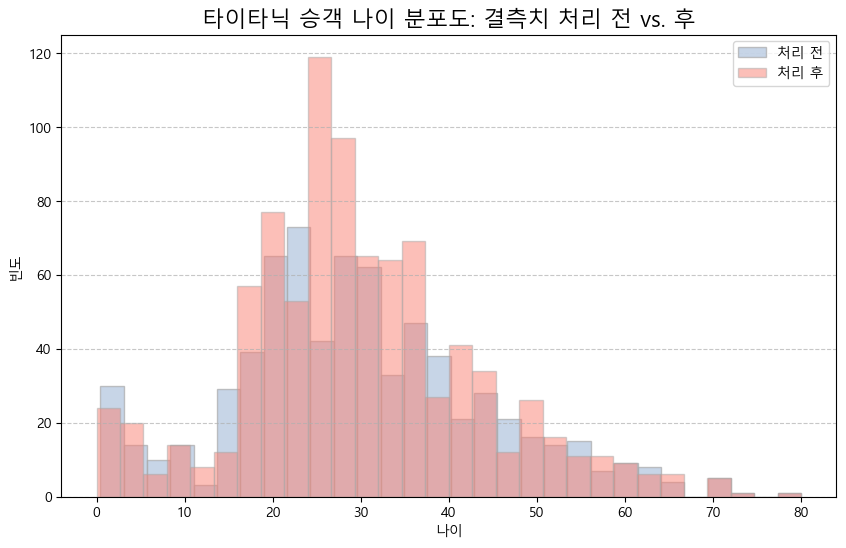

In [3]:
titanic_copy = titanic.copy()

titanic_copy.drop(columns=['sibsp', 'parch', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], inplace=True, errors='ignore')

titanic_copy['embarked'].fillna(titanic_copy['embarked'].mode()[0], inplace=True)

titanic_copy.isnull().sum()

# 'sex', 'embarked', 'alone' 컬럼은 문자열이라 숫자로 대체하기
titanic_copy['sex'].replace({'male': 1, 'female': 0}, inplace=True)
titanic_copy['embarked'].replace({'S': 0, 'C': 1, 'Q': 2}, inplace=True)

age_train = titanic_copy[titanic_copy['age'].notnull()].copy()
age_test = titanic_copy[titanic_copy['age'].isnull()].copy()

# 훈련, 테스트 셋 분리
X_train = age_train[['pclass', 'sex', 'fare', 'embarked']]
y_train = age_train['age']

X_test = age_test[['pclass', 'sex', 'fare', 'embarked']]

from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor(n_neighbors=9)
knr.fit(X_train, y_train)

age_predict = knr.predict(X_test)

# age 결측치를 예측값으로 채우고, 나이는 실수형이 나올 수 없기 때문에 정수형으로 변환
titanic_copy.loc[titanic_copy['age'].isnull(), 'age'] = age_predict
titanic_copy['age'] = titanic_copy['age'].astype(int)

# 최종적으로 age 컬럼 결측치 개수 확인
print(f'최종 age 컬럼 결측치 개수 : {titanic_copy['age'].isnull().sum()}')

plt.figure(figsize=(10, 6))

plt.hist(titanic['age'].dropna(), bins=30, color='lightsteelblue', edgecolor='darkgray', label='처리 전', alpha=0.7)

plt.hist(titanic_copy['age'], bins=30, color='salmon', edgecolor='darkgray', label='처리 후', alpha=0.5)

plt.title('타이타닉 승객 나이 분포도: 결측치 처리 전 vs. 후', fontsize=16)
plt.xlabel('나이')
plt.ylabel('빈도')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**그래프 해석**
- 파란색 막대 (처리 전): 원본 데이터의 나이 분포를 보여줍니다. 그래프를 보면 20대 후반, 30대 초반 등 중간중간에 비어있는 부분이 보이는데, 이는 Age 컬럼의 결측치 때문입니다.

- 주황색 막대 (처리 후): KNN으로 결측치를 채운 titanic_copy 데이터의 나이 분포입니다. 파란색 그래프에서 비어있던 부분들이 매끈하게 채워진 것을 확인할 수 있습니다. 특히 20~40세 구간에 데이터가 가장 많았다는 점을 반영하여 빈 공간이 자연스럽게 채워졌습니다.

In [4]:
titanic_copy

,survived,pclass,sex,age,fare,embarked
0,0,3,1,22,7.2500,0
1,1,1,0,38,71.2833,1
2,1,3,0,26,7.9250,0
3,1,1,0,35,53.1000,0
4,0,3,1,35,8.0500,0
...,...,...,...,...,...,...
886,0,2,1,27,13.0000,0
887,1,1,0,19,30.0000,0
888,0,3,0,27,23.4500,0
889,1,1,1,26,30.0000,1


## KNN 분류

In [5]:
X = titanic_copy[['pclass', 'sex', 'age', 'fare', 'embarked']]
y = titanic_copy['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)

knn_score = knn.score(X_test, y_test)

print(f'KNN 점수: {knn_score:.4f}')

KNN 점수: 0.6906


## Logistic회귀 분류

In [6]:
lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)

lr_score = lr.score(X_test, y_test)

print(f'Logistic 점수: {lr_score:.4f}')

Logistic 점수: 0.7848


## 결정트리 분류

테스트 데이터 점수: 0.8117


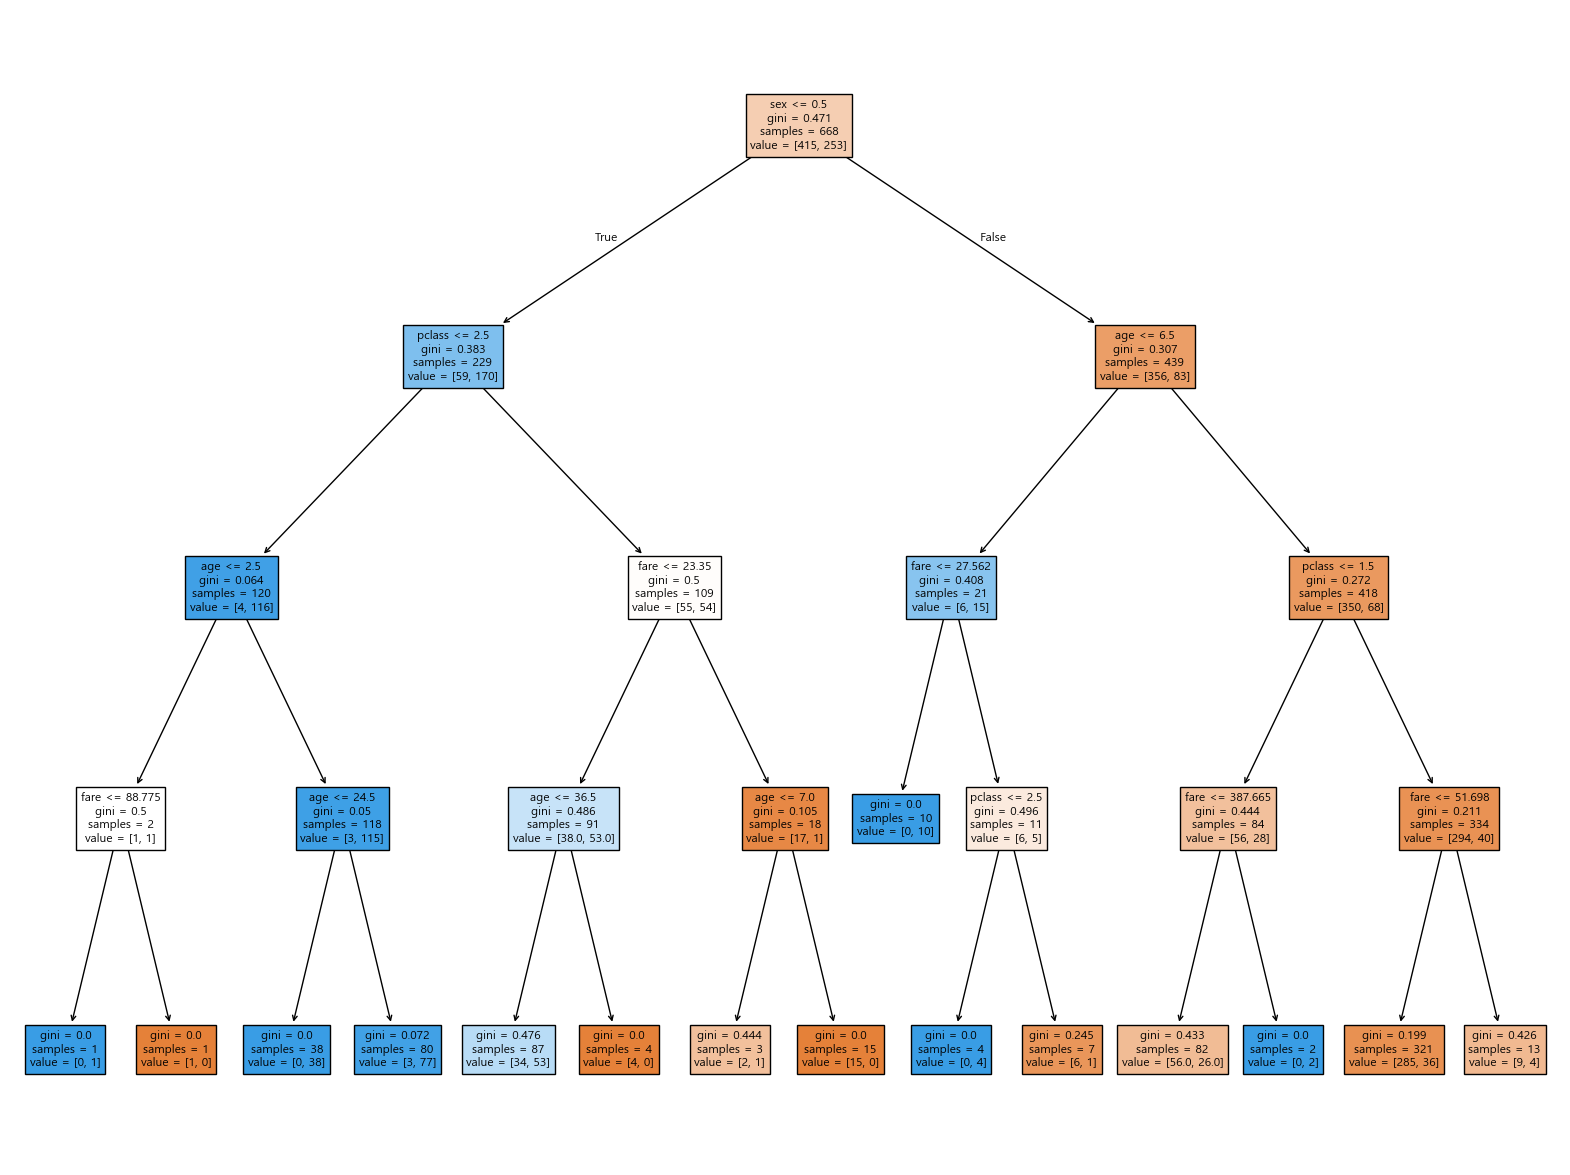

In [7]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)

dt.fit(X_train, y_train)

dt_score = dt.score(X_test, y_test)
print(f'테스트 데이터 점수: {dt_score:.4f}')

plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['pclass', 'sex', 'age', 'fare', 'embarked', 'alone'])
plt.show()

**결정트리모델의 특성 중요도 점수**

In [8]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# 특성 이름과 특성 중요도 점수를 연결하여 데이터프레임 생성
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': dt_classifier.feature_importances_})

# 중요도 점수를 기준으로 내림차순 정렬
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

print("특성 중요도 점수:")
print(feature_importances)

특성 중요도 점수:
    feature  importance
1       sex    0.310537
3      fare    0.284290
2       age    0.244345
0    pclass    0.131138
4  embarked    0.029691


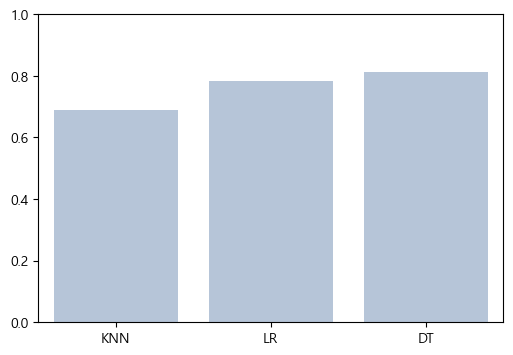

In [9]:
plt.figure(figsize=(6, 4))
sns.barplot(y=[knn_score, lr_score, dt_score], x=['KNN', 'LR', 'DT'], color='lightsteelblue')
plt.ylim(0, 1)
plt.show()

**--------------------------------------------------------------------------------------------------------------------------------------------------**

In [10]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# 실험실에서 기능 활성화
from sklearn.experimental import enable_iterative_imputer
# MICE (다른 특성으로 결측 대체하기)
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

titanic = sns.load_dataset('titanic')

features = ['pclass', 'sex', 'age', 'fare', 'embarked']
target = 'survived'

df = titanic[features + [target]]

# 수동 결측치 채우기 -> embarked (탑승항구) == 대부분이 'S' 
df['embarked'].fillna('S', inplace=True)

# One-Hot Encoding (OHE) -> 범주형 데이터를 T/F로 이루어진 여러개의 컬럼으로 변환
# Pros -> 숫자 0, 1, 2 는 크기 순서가 생겨 해석이 잘못될 수 있음
# Cons -> 카테고리가 많으면 차원이 늘어남
df = pd.get_dummies(df, columns=['sex', 'embarked'])

# encoder = OneHotEncoder(sparse_output=False, drop=None)
# df_encoded = pd.DataFrame(encoder.fit_transform(df[['sex', 'embarked']]), columns=df.columns)


# MICE 결측치가 있는 변수를 다른 변수들을 이용해 반복적으로 예측
imputer = IterativeImputer(
    max_iter=10,
    random_state=42
)

df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df_imputed.head()

,pclass,age,fare,survived,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,3.0,22.0,7.2500,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,38.0,71.2833,1.0,1.0,0.0,1.0,0.0,0.0
2,3.0,26.0,7.9250,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,35.0,53.1000,1.0,1.0,0.0,0.0,0.0,1.0
4,3.0,35.0,8.0500,0.0,0.0,1.0,0.0,0.0,1.0


In [11]:
X = df_imputed.drop('survived', axis=1)
y = df_imputed[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

## KNN 분류

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
score_knn = knn.score(X_test_scaled, y_test)
print(f'KNN: {score_knn:.5f}')

KNN: 0.81006


## Logistic회귀 분류

In [13]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
score_lr = lr.score(X_test_scaled, y_test)
print(f'Logistic Regression: {score_lr:.5f}')

Logistic Regression: 0.80447


## 결정트리 분류

In [14]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
score_dt = dt.score(X_test, y_test)
print(f'Descision Tree: {score_dt:.5f}')

Descision Tree: 0.83799


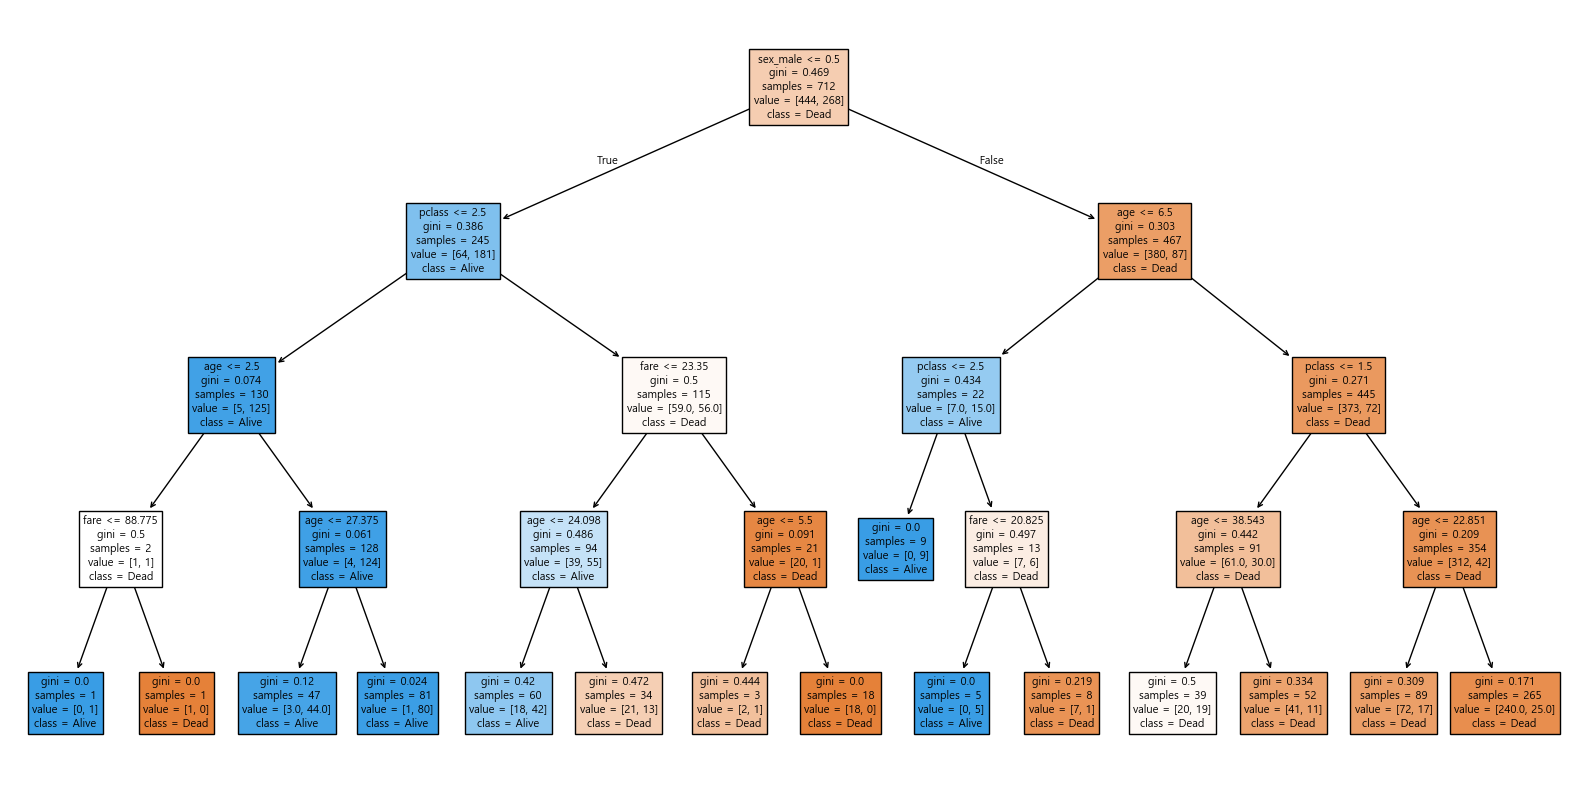

In [15]:
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=['Dead', 'Alive'], filled=True)
plt.show()

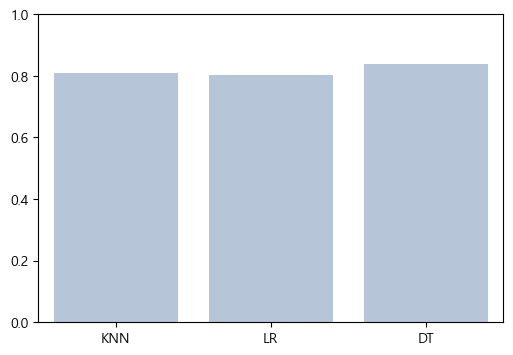

In [16]:
plt.figure(figsize=(6, 4))
sns.barplot(y=[score_knn, score_lr, score_dt], x=['KNN', 'LR', 'DT'], color='lightsteelblue')
plt.ylim(0, 1)
plt.show()